## Alternative Model (Preprocessing)
You need to run this before you run notebook 4b.

The wavs in your dataset will be converted to 9bit linear and 80-band mels.

In [17]:
cd /home/erogol/Projects/WaveRNN/

/home/erogol/Projects/WaveRNN


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import librosa
import matplotlib.pyplot as plt
import math, pickle, os, glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
from utils import *
from utils.display import *
from utils.generic_utils import load_config
from utils.audio import AudioProcessor
import IPython.display as ipd
from multiprocessing import Pool

In [5]:
bits = 9
notebook_name = 'wavernn_ljspeech_ref'
config_path = '../TTS/config.json'

CONFIG = load_config(config_path)
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, CONFIG.preemphasis,
                    griffin_lim_iters=50)   

 > Setting up Audio Processor...
 | > fft size: 2048, hop length: 275, win length: 1100


In [6]:
# Point SEG_PATH to a folder containing your training wavs 
# Doesn't matter if it's LJspeech, CMU Arctic etc. it should work fine
SEG_PATH = '/home/erogol/Data/LJSpeech-1.1/wavs/' 
DATA_PATH = f'data/{notebook_name}/'
%mkdir -p $DATA_PATH

In [7]:
def get_files(path, extension='.wav') :
    filenames = []
    for filename in glob.iglob(f'{path}/**/*{extension}', recursive=True):
        filenames += [filename]
    return filenames

In [8]:
wav_files = get_files(SEG_PATH)
print(len(wav_files))

13100


In [9]:
# def convert_file(path) :
#     wav = ap.load_wav(path, encode=False)
#     mel = ap.melspectrogram(wav)
#     quant = (wav + 1.) * (2**bits - 1) / 2
#     return mel.astype(np.float32), quant.astype(np.int)

def convert_file(path) :
    wav = ap.load_wav(path)
    quant = ap.mulaw_encode(wav, 2**bits)
    mel = ap.melspectrogram(wav)
    return mel.astype(np.float32), quant.astype(np.int)

In [24]:
wav_file = "/home/erogol/Data/LJSpeech-1.1/wavs_gl/LJ007-0073.wav"
m, x = convert_file(wav_file)

In [25]:
print(x.max())
print(x.min())

498
0


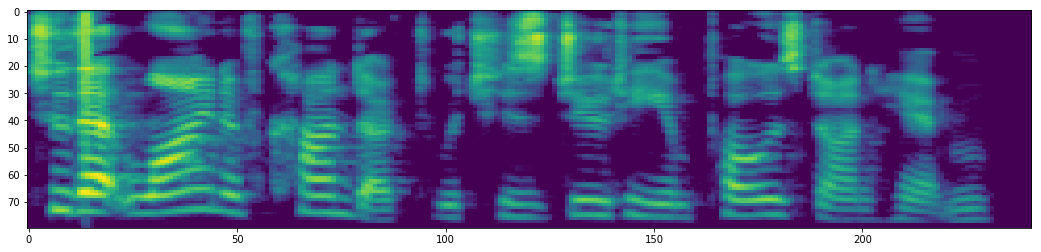

In [26]:
plot_spec(m)

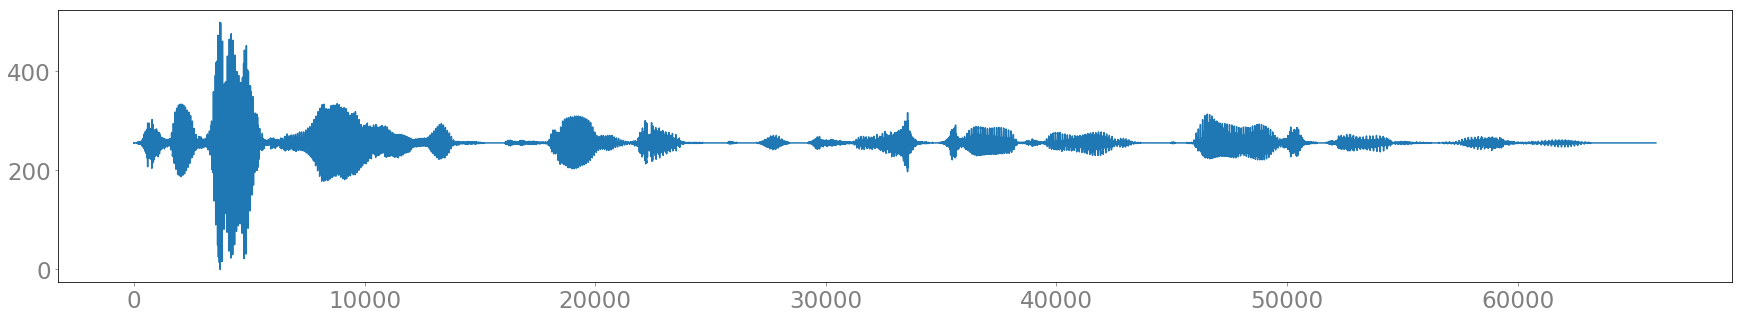

In [27]:
plot(x)

In [28]:
# x = 2 * x / (2**bits - 1) - 1
x_decoder = ap.mulaw_decode(x, 2**bits)
librosa.output.write_wav(DATA_PATH + 'test_quant.wav', x_decoder, sr=CONFIG.sample_rate)
ipd.Audio(wav_file) # load a local WAV file

In [13]:
QUANT_PATH = DATA_PATH + 'quant/'
MEL_PATH = DATA_PATH + 'mel/'
%mkdir -p $QUANT_PATH
%mkdir -p $MEL_PATH

In [14]:
wav_files[0].split('/')[-1][:-4]

'LJ039-0124'

In [15]:
def process_wav(wav_path):
    idx = wav_path.split('/')[-1][:-4]
    m, x = convert_file(wav_path)
    np.save(f'{MEL_PATH}{idx}.npy', m)
    np.save(f'{QUANT_PATH}{idx}.npy', x)
    return idx

In [16]:
# This will take a while depending on size of dataset
with Pool(8) as p:
    dataset_ids = list(tqdm(p.imap(process_wav, wav_files), total=len(wav_files)))

Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/erogol/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-8:
  File "/home/erogol/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/erogol/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/erogol/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/erogol/miniconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/erogol/miniconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "<ipython-input-15-2eb81f3da07d>", line 3,

KeyboardInterrupt: 

In [ ]:
with open(DATA_PATH + 'dataset_ids.pkl', 'wb') as f:
    pickle.dump(dataset_ids, f)